In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pycountry
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

import preprocess as pre

In [3]:
users_file = "BX-Users.csv"
books_file = "BX-Books.csv"
rating_file = "BX-Ratings.csv"
new_users_file = "BX-NewBooksUsers.csv"
new_books_file = "BX-NewBooks.csv"
new_ratings_file = "BX-NewBooksRatings.csv"

,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Rating_Category
0,256536,las animas,colorado,united states,5.0,0-10,0140373373,10,pride and prejudice (puffin classics),jane austen,1995,puffin books,high
1,10199,eltham,victoria,australia,17.0,10-20,0140373373,7,pride and prejudice (puffin classics),jane austen,1995,puffin books,high
2,6894,colorado springs,colorado,united states,20.0,10-20,0140373373,9,pride and prejudice (puffin classics),jane austen,1995,puffin books,high
3,23902,london,england,united kingdom,25.0,20-30,0140373373,10,pride and prejudice (puffin classics),jane austen,1995,puffin books,high
4,42935,kelowna,british columbia,canada,31.0,30-40,0140373373,8,pride and prejudice (puffin classics),jane austen,1995,puffin books,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204159,128835,bellingham,washington,united states,60.0,50-60,0449200183,7,braided lives,marge piercy,1983,ballantine books,high
204160,118632,atlanta,georgia,united states,64.0,60-70,0312853807,7,zero coupon,paul erdman,1993,st martins pr,high
204161,160697,erie,pennsylvania,united states,67.0,60-70,0312853807,7,zero coupon,paul erdman,1993,st martins pr,high
204162,14449,saskatoon,saskatchewan,canada,72.0,70-80,0312853807,8,zero coupon,paul erdman,1993,st martins pr,high


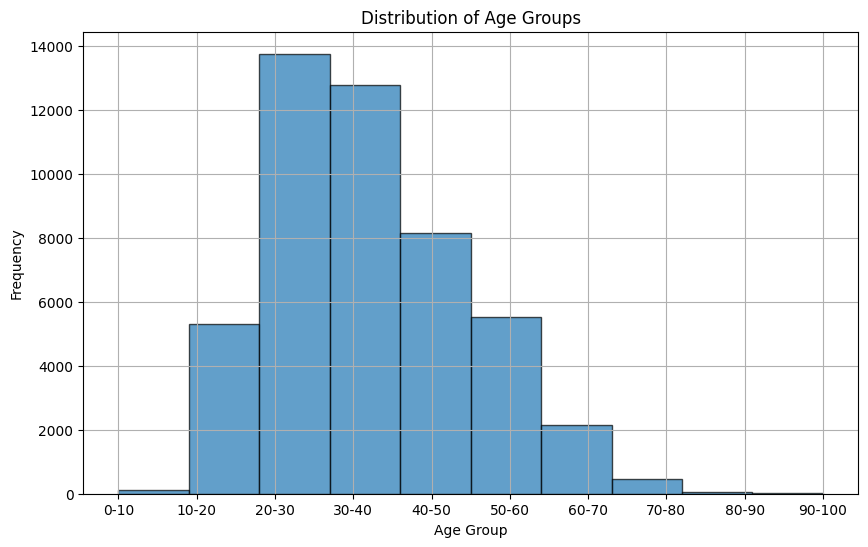

In [4]:
users_df = pd.read_csv(users_file)
ratings_df = pd.read_csv(rating_file)
books_df = pd.read_csv(books_file)

# Imputation missing data and discretise the age based on an age group
users_df = pre.ages_imputation(pre.weighted_age_dict(users_file), users_df)
users_df = pre.city_imputation(users_df)
users_df = pre.state_imputation(users_df)
users_df = pre.country_imputation(users_df)
merged_df = pre.discretising(users_df, ratings_df, books_df)
merged_df = pre.author_imputation(merged_df)
merged_df = pre.text_process(merged_df)
merged_df.to_csv("merge.csv", index=False)

merged_df

Text processing frist step: Write everyting into uppercase, unitify the counties of users.

# For Test Set

/Users/milesli/Desktop/Age-Based-Personalised-Books-Recommendation-System/Report&Coding/data&code/preprocess.py:177: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Book-Author"].fillna("NO AUTHOR", inplace=True)


,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Rating_Category
0,108141,los molinos,california,united states,5.0,0-10,0684143127,9,"ants, indians, and little dinosaurs",alan ternes,1975,scribner,high
1,104059,brisbane,queensland,australia,5.0,0-10,0345377672,8,body count,william x. kienzle,1993,fawcett books,high
2,104059,brisbane,queensland,australia,5.0,0-10,0451402049,8,midsummer magic,catherine coulter,1989,onyx books,high
3,248259,miami lakes,florida,united states,5.0,0-10,0312929641,8,the circle,david poyer,1993,st. martin's press,high
4,248259,miami lakes,florida,united states,5.0,0-10,0380713985,8,the blue deep,layne heath,1994,harper mass market paperbacks,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,181598,ardrossan,alberta,canada,85.0,80-90,1853267333,8,count of monte cristo,alexandre dumas,1998,ntc/contemporary publishing,high
23141,225867,despair,indiana,united states,93.0,90-100,0393322432,5,people who knock on the door,patricia highsmith,2001,w.w. norton & company,medium
23142,64417,goslar,niedersachsen,germany,95.0,90-100,3423107952,7,die unendliche geschichte,ende,0,deutscher taschenbuch verlag (dtv),high
23143,114865,croydon,victoria,australia,97.0,90-100,0586037950,9,the golden notebook,doris may lessing,1979,granada publishing,high


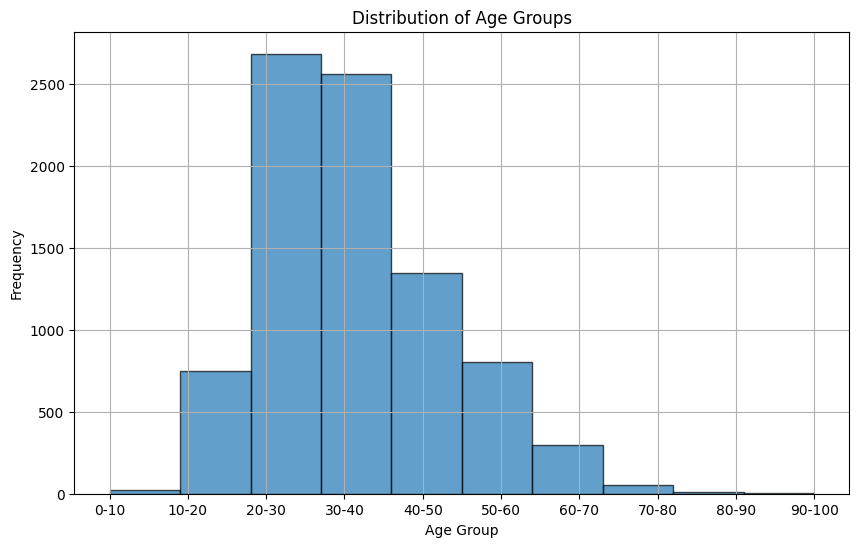

In [4]:
new_users_df = pd.read_csv(new_users_file)
new_ratings_df = pd.read_csv(new_ratings_file)
new_books_df = pd.read_csv(new_books_file)

# Imputation missing data and discretise the age based on an age group
new_users_df = pre.ages_imputation(pre.weighted_age_dict(new_users_file), new_users_df)
new_users_df = pre.city_imputation(new_users_df)
new_users_df = pre.state_imputation(new_users_df)
new_users_df = pre.country_imputation(new_users_df)
test_merged_df = pre.discretising(new_users_df, new_ratings_df, new_books_df)
test_merged_df = pre.author_imputation(test_merged_df)
test_merged_df = pre.text_process(test_merged_df)
test_merged_df

In [23]:


for feature in [
    "User-City",
    "User-State",
    "User-Country",
    "Age-Group",
    "Book-Author",
    "Year-Of-Publication",
    "Book-Publisher",
    "Book-Title"
]:
    print(
        feature,
        pre.compute_information_gain(
            merged_df[feature], merged_df["Rating_Category"]
        ).round(4),
    )

User-City 0.1038
User-State 0.0166
User-Country 0.0022
Age-Group 0.0008
Book-Author 0.0751
Year-Of-Publication 0.0027
Book-Publisher 0.0231
Book-Title 0.1435


In [46]:
# Deleted Features with low IG to train the DT
new_features = [
    "User-City",
    "Book-Author",
    "Book-Title",
]

train_X = OrdinalEncoder().fit_transform(merged_df[new_features])
train_y = OrdinalEncoder().fit_transform(merged_df[["Rating_Category"]])

test_X = OrdinalEncoder().fit_transform(test_merged_df[new_features])
test_y = OrdinalEncoder().fit_transform(test_merged_df[["Rating_Category"]])

# Initialise the DT
dt_classifier = DecisionTreeClassifier(criterion="entropy")

# Train the model
dt_classifier.fit(train_X, train_y)

# Do Cross validation to test the training process
cross_validation = cross_val_score(dt_classifier, train_X, train_y, cv=10)
print("Cross Validation Scores:", cross_validation)
print("Average Score:", np.mean(cross_validation))

pred_y = dt_classifier.predict(test_X)

accuracy = accuracy_score(pred_y, test_y)
print("Final Accuracy:", accuracy)

Cross Validation Scores: [0.665132   0.66087084 0.64745065 0.66150757 0.65438871 0.54893221
 0.65414381 0.6473844  0.65012735 0.65522139]
Average Score: 0.6445158945872753
Final Accuracy: 0.6225102613955498


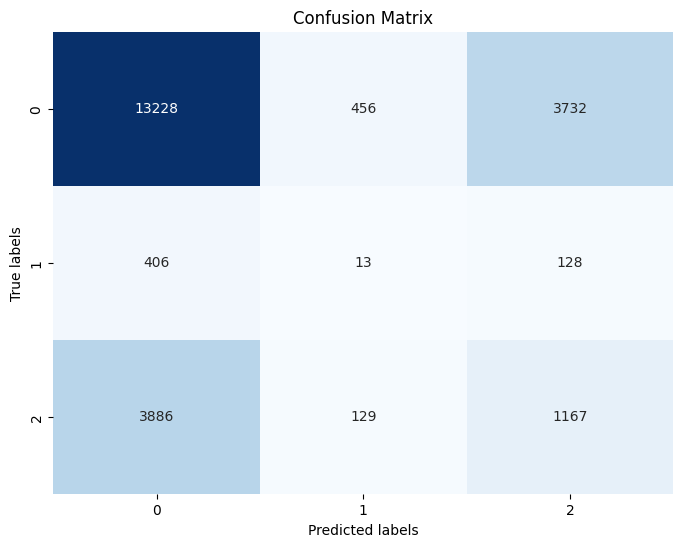

In [47]:
# Confusion matrix
cm = confusion_matrix(test_y, pred_y)

# Visulisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

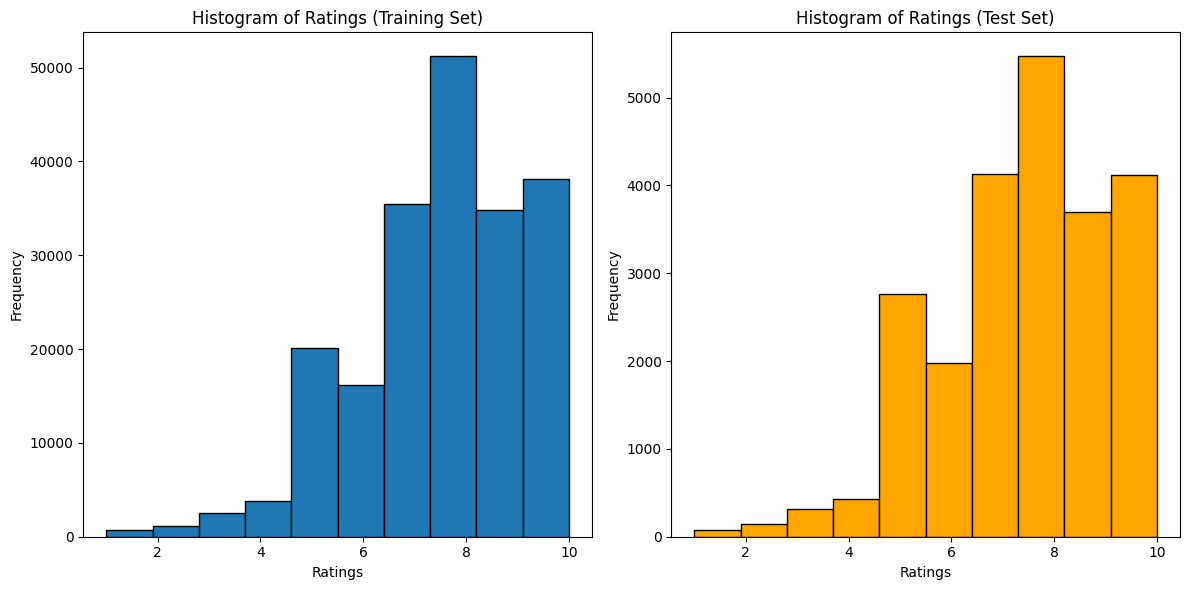

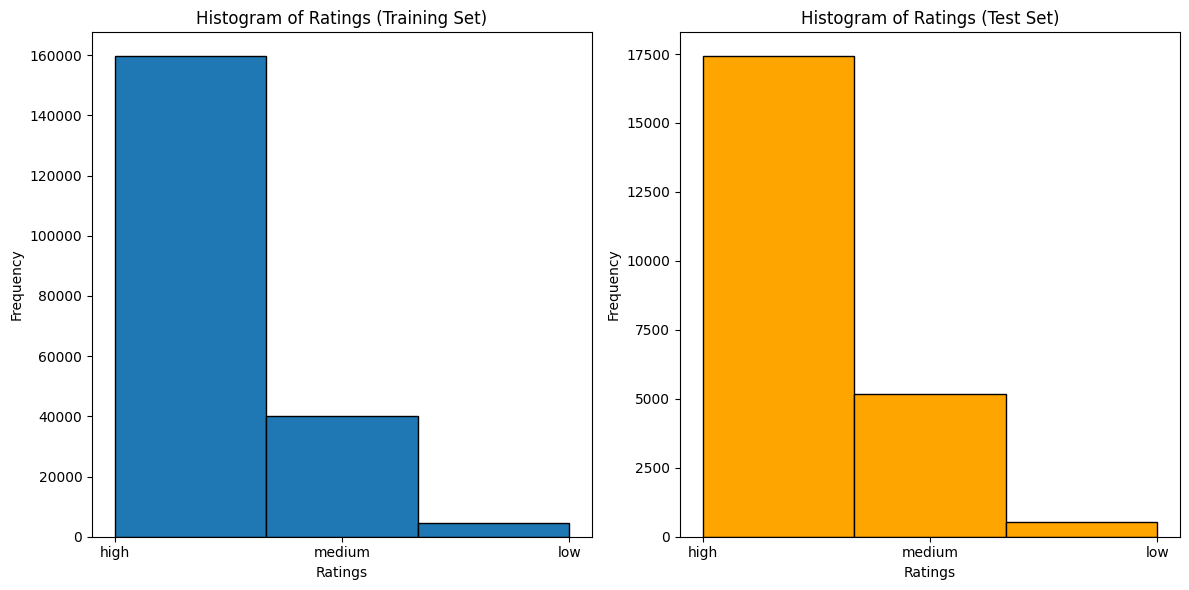

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# For Rating
axs[0].hist(merged_df["Book-Rating"], bins=10, edgecolor="black")
axs[0].set_xlabel("Ratings")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of Ratings (Training Set)")

axs[1].hist(test_merged_df["Book-Rating"], bins=10, edgecolor="black", color="orange")
axs[1].set_xlabel("Ratings")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Ratings (Test Set)")

plt.tight_layout()

# For Rating category
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(merged_df["Rating_Category"], bins=3, edgecolor="black")
axs[0].set_xlabel("Ratings")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of Ratings (Training Set)")

axs[1].hist(test_merged_df["Rating_Category"], bins=3, edgecolor="black", color="orange")
axs[1].set_xlabel("Ratings")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Ratings (Test Set)")

plt.tight_layout()

## BOW vectors for books' name

In [5]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Assuming merged_df["Book-Title"] contains the book titles
book_names = set(merged_df["Book-Title"])

# Preprocessing and tokenization
def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and duplicates
    tokens = set([word for word in tokens if word not in stopwords.words('english')])
    return " ".join(tokens)

# Preprocess book names
preprocessed_books = [preprocess_text(book) for book in book_names]

# Creating bag-of-words vectors
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(preprocessed_books)

[nltk_data] Downloading package punkt to /Users/milesli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milesli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


15976


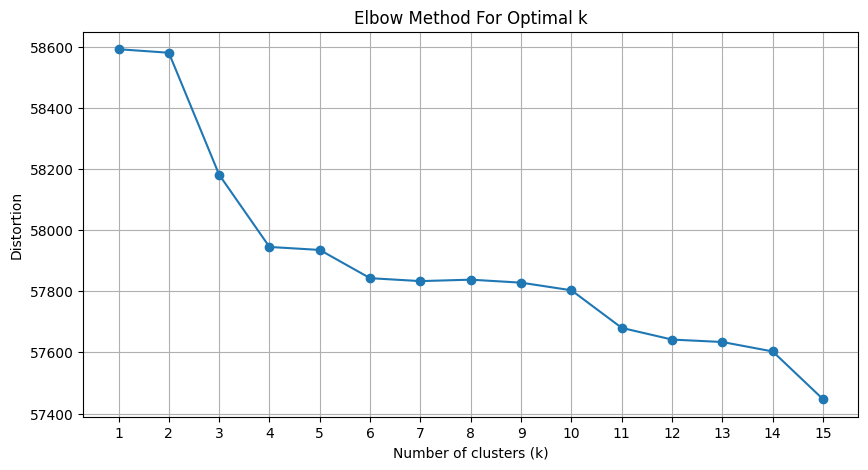

In [18]:
# Calculate distortion for a range of number of cluster
distortions = []
book_set = set(merged_df["Book-Title"])
print(len(book_set))
K_range = range(1, 16)  # Trying k from 1 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bow_matrix)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(10, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [19]:
# Perform K-means clustering
num_clusters = 4  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(bow_matrix)

# Get cluster labels and assign each book to a cluster
cluster_labels = kmeans.labels_
book_clusters = {}
for i, book in enumerate(book_names):
    cluster = cluster_labels[i]
    if cluster not in book_clusters:
        book_clusters[cluster] = []
    book_clusters[cluster].append(book)

# Print out the clusters
for cluster, books in book_clusters.items():
    print(f"Cluster {cluster + 1}:")
    print(len(books))
    '''for book in books:
        print(f"- {book}")'''

Cluster 1:
15595
Cluster 2:
190
Cluster 4:
124
Cluster 3:
67
